In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma0p1/fiducial/sfe_ff003/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 20)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass         isMultiple       compMass            systemMass              e                log_a               age        
-------------------- ---------- -------------------- ------------------- ------------------- ------------------ ------------------
  12.818908070209863        0.0                   []  12.818908070209863                 nan                nan  19.28537582919208
  4.9549285763343764        0.0                   []  4.9549285763343764                 nan                nan  19.28537582919208
   8.067212571515112        0.0                   []   8.067212571515112                 nan                nan 17.289245730887043
   6.946275907178013        0.0                   []   6.946275907178013                 nan                nan 18.475896770218082
                 ...        ...                  ...                 ...                 ...                ...                ...
  0.9489406533298774        1.0 [0.8626064417911955]  1.8115470951210728  0.5844278

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 7.138402542266087
Max log age = 7.3011106695566514
Min level age = 13753161.482015437
Max level age = 20003715.51513672


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1641
[0.3241624348251086, 0.05095402070602342, 0.06758268036155689, 0.2634619140232143, 3.0305143670780916, 0.019100480058271217, 0.013328533048159051, 0.12267811531436108, 0.16160452370753137, 0.01442445815642728, 0.09685313419544767, 0.02206295254684064, 0.026062091840581544, 0.23206340246858242, 0.010659884204343559, 0.09138690863698644, 0.021026970199695943, 0.07079943158521453, 0.0581860983356197, 0.015522067753595834, 0.11540233656694762, 0.015276826165350291, 0.03731041177184101, 0.25969868292158427, 0.20332028766917049, 0.032323356109109164, 0.18928016428521058, 0.09898339956998825, 0.11899845630244968, 0.21501117944717407, 0.06470821052789688, 0.016764014959335327, 0.04054572198307689, 0.03195300950979017, 0.031136754900217056, 0.09390845096561119, 0.1048092469573021, 0.03370909553992068, 0.13829360753641778, 0.4990076216989321, 0.20981368313804674, 0.12287444910273947, 0.016603971205854686, 0.04813299634079317, 0.23601408835929072, 1.8674397463219425, 0.04728714545608921, 0.0

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[7.13033377 7.14612804 7.161368   7.17609126 7.1903317  7.20411998
 7.21748394 7.23044892 7.24303805 7.25527251 7.26717173 7.2787536
 7.29003461 7.30103    7.31175386]
[13500000. 14000000. 14500000. 15000000. 15500000. 16000000. 16500000.
 17000000. 17500000. 18000000. 18500000. 19000000. 19500000. 20000000.
 20500000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

Changing to logg=2.50 for T= 13896 logg=2.48
Changing to logg=2.50 for T= 13734 logg=2.46
Changing to logg=2.50 for T= 13574 logg=2.44
Changing to logg=2.50 for T= 13415 logg=2.42
Changing to logg=2.50 for T= 13259 logg=2.41
Changing to logg=2.50 for T= 13104 logg=2.39
Changing to logg=2.50 for T= 12951 logg=2.37
Changing to logg=2.50 for T= 12800 logg=2.35
Changing to logg=2.50 for T= 12651 logg=2.33
Changing to logg=2.50 for T= 12503 logg=2.31
Changing to logg=2.50 for T= 12357 logg=2.29
Changing to logg=2.50 for T= 12213 logg=2.27
Changing to logg=2.50 for T= 12070 logg=2.25
Changing to logg=2.50 for T= 11929 logg=2.23
Changing to logg=2.50 for T= 11789 logg=2.21
Changing to logg=2.00 for T= 10236 logg=1.98
Changing to logg=2.00 for T= 10117 logg=1.96
Changing to logg=2.00 for T=  9998 logg=1.94
Changing to logg=2.00 for T=  9881 logg=1.93
Changing to logg=2.00 for T=  9766 logg=1.91
Changing to logg=2.00 for T=  9651 logg=1.89
Changing to logg=2.00 for T=  9538 logg=1.87
Changing t

Changing to logg=2.50 for T= 11758 logg=2.29
Changing to logg=2.00 for T=  9752 logg=1.99
Changing to logg=2.00 for T=  9613 logg=1.96
Changing to logg=2.00 for T=  9475 logg=1.94
Changing to logg=2.00 for T=  9340 logg=1.92
Changing to logg=2.00 for T=  9206 logg=1.90
Changing to logg=2.00 for T=  9075 logg=1.87
Isochrone generation took 37.159801 s.
Making photometry for isochrone: log(t) = 7.19  AKs = 0.00  dist = 410
     Starting at:  2023-12-19 04:12:04.848833   Usually takes ~5 minutes
Starting filter: jwst,F115W   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.100 Msun  T =  3002 K  m_jwst_F115W = 16.11
M =   1.726 Msun  T =  8118 K  m_jwst_F115W = 10.13
M =   5.782 Msun  T = 18240 K  m_jwst_F115W = 7.47
M =  12.708 Msun  T = 21651 K  m_jwst_F115W = 4.37
M =  12.918 Msun  T = 11261 K  m_jwst_F115W = 2.25
M =  12.935 Msun  T =  3553 K  m_jwst_F115W = 0.20
Starting filter: jwst,F182M   Elapsed time: 12.19 seconds
Starting synthetic photometry
M =   0.100 Msun  T

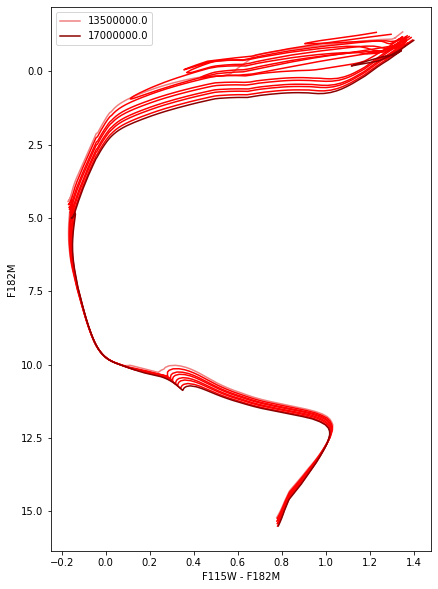

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 12.818908070209863 is outside the range of the isochrone.
Desired mass 12.818908070209863 is outside the range of the isochrone.
Desired mass 14.39111404199985 is outside the range of the isochrone.
Desired mass 0.01651090504541876 is outside the range of the isochrone.
Desired mass 0.01651090504541876 is outside the range of the isochrone.
Desired mass 0.010346987194598664 is outside the range of the isochrone.
Desired mass 0.010346987194598664 is outside the range of the isochrone.
Desired mass 0.019465836724068517 is outside the range of the isochrone.
Desired mass 0.019465836724068517 is outside the range of the isochrone.
Desired mass 0.01080286592662339 is outside the range of the isochrone.
Desired mass 0.01080286592662339 is outside the range of the isochrone.
Desired mass 18.0065865909995 is outside the range of the isochrone.
Desired mass 18.0065865909995 is outside the range of the isochrone.
Desired mass 17.90664494680176 is outside the range of the isochrone.


Desired mass 0.01917802299142728 is outside the range of the isochrone.
Desired mass 0.01917802299142728 is outside the range of the isochrone.
Desired mass 0.10399167592676428 is outside the range of the isochrone.
Desired mass 0.10399167592676428 is outside the range of the isochrone.
Desired mass 0.026538638061559518 is outside the range of the isochrone.
Desired mass 0.026538638061559518 is outside the range of the isochrone.
Desired mass 0.010657688330139425 is outside the range of the isochrone.
Desired mass 0.010657688330139425 is outside the range of the isochrone.
Desired mass 0.021364805971801567 is outside the range of the isochrone.
Desired mass 0.021364805971801567 is outside the range of the isochrone.
Desired mass 0.0668519323258684 is outside the range of the isochrone.
Desired mass 0.0668519323258684 is outside the range of the isochrone.
Desired mass 0.019129713358451997 is outside the range of the isochrone.
Desired mass 0.019129713358451997 is outside the range of t

Desired mass 0.08239035204775859 is outside the range of the isochrone.
Desired mass 0.08239035204775859 is outside the range of the isochrone.
Desired mass 0.09312776121853397 is outside the range of the isochrone.
Desired mass 0.09312776121853397 is outside the range of the isochrone.
Desired mass 0.07258652936850817 is outside the range of the isochrone.
Desired mass 0.07258652936850817 is outside the range of the isochrone.
Desired mass 0.09353702410132782 is outside the range of the isochrone.
Desired mass 0.09353702410132782 is outside the range of the isochrone.
Desired mass 0.021353985627632684 is outside the range of the isochrone.
Desired mass 0.021353985627632684 is outside the range of the isochrone.
Desired mass 0.06248531572479349 is outside the range of the isochrone.
Desired mass 0.06248531572479349 is outside the range of the isochrone.
Desired mass 0.02758837863247708 is outside the range of the isochrone.
Desired mass 0.02758837863247708 is outside the range of the i

Desired mass 0.019392910728138785 is outside the range of the isochrone.
Desired mass 0.019392910728138785 is outside the range of the isochrone.
Desired mass 0.03573279556093948 is outside the range of the isochrone.
Desired mass 0.03573279556093948 is outside the range of the isochrone.
Desired mass 0.06131493810709214 is outside the range of the isochrone.
Desired mass 0.06131493810709214 is outside the range of the isochrone.
Desired mass 0.016553524038955093 is outside the range of the isochrone.
Desired mass 0.016553524038955093 is outside the range of the isochrone.
Desired mass 0.07229174044281313 is outside the range of the isochrone.
Desired mass 0.07229174044281313 is outside the range of the isochrone.
Desired mass 0.08921199780237954 is outside the range of the isochrone.
Desired mass 0.08921199780237954 is outside the range of the isochrone.
Desired mass 0.08091738490037051 is outside the range of the isochrone.
Desired mass 0.08091738490037051 is outside the range of the

Desired mass 0.07909232535120164 is outside the range of the isochrone.
Desired mass 0.07909232535120164 is outside the range of the isochrone.
Desired mass 0.02018790355198907 is outside the range of the isochrone.
Desired mass 0.02018790355198907 is outside the range of the isochrone.
Desired mass 0.07492868915071955 is outside the range of the isochrone.
Desired mass 0.07492868915071955 is outside the range of the isochrone.
Desired mass 0.09861381855989972 is outside the range of the isochrone.
Desired mass 0.09861381855989972 is outside the range of the isochrone.
Desired mass 0.06672175851991183 is outside the range of the isochrone.
Desired mass 0.06672175851991183 is outside the range of the isochrone.
Desired mass 0.10150817036628723 is outside the range of the isochrone.
Desired mass 0.10150817036628723 is outside the range of the isochrone.
Desired mass 0.01971857061502275 is outside the range of the isochrone.
Desired mass 0.01971857061502275 is outside the range of the iso

Desired mass 0.06433518975973129 is outside the range of the isochrone.
Desired mass 0.06433518975973129 is outside the range of the isochrone.
Desired mass 0.08312205577136116 is outside the range of the isochrone.
Desired mass 0.08312205577136116 is outside the range of the isochrone.
Desired mass 0.03558069598598901 is outside the range of the isochrone.
Desired mass 0.03558069598598901 is outside the range of the isochrone.
Desired mass 0.025118576999824397 is outside the range of the isochrone.
Desired mass 0.025118576999824397 is outside the range of the isochrone.
Desired mass 0.0815387382909392 is outside the range of the isochrone.
Desired mass 0.0815387382909392 is outside the range of the isochrone.
Desired mass 0.031289594238665654 is outside the range of the isochrone.
Desired mass 0.031289594238665654 is outside the range of the isochrone.
Desired mass 0.059690061010457963 is outside the range of the isochrone.
Desired mass 0.059690061010457963 is outside the range of the

Desired mass 0.02022025063348097 is outside the range of the isochrone.
Desired mass 0.02022025063348097 is outside the range of the isochrone.
Desired mass 0.05659758299589157 is outside the range of the isochrone.
Desired mass 0.05659758299589157 is outside the range of the isochrone.
Desired mass 0.06758954435196177 is outside the range of the isochrone.
Desired mass 0.06758954435196177 is outside the range of the isochrone.
Desired mass 0.08123506182834286 is outside the range of the isochrone.
Desired mass 0.08123506182834286 is outside the range of the isochrone.
Desired mass 0.06493011125176093 is outside the range of the isochrone.
Desired mass 0.06493011125176093 is outside the range of the isochrone.
Desired mass 0.05527057090192753 is outside the range of the isochrone.
Desired mass 0.05527057090192753 is outside the range of the isochrone.
Desired mass 0.017611691610508805 is outside the range of the isochrone.
Desired mass 0.017611691610508805 is outside the range of the i

Desired mass 0.0599981656751241 is outside the range of the isochrone.
Desired mass 0.0599981656751241 is outside the range of the isochrone.
Desired mass 0.03361565168649726 is outside the range of the isochrone.
Desired mass 0.03361565168649726 is outside the range of the isochrone.
Desired mass 0.08565120064571564 is outside the range of the isochrone.
Desired mass 0.08565120064571564 is outside the range of the isochrone.
Desired mass 0.0785553922764272 is outside the range of the isochrone.
Desired mass 0.0785553922764272 is outside the range of the isochrone.
Desired mass 0.0727066930894829 is outside the range of the isochrone.
Desired mass 0.0727066930894829 is outside the range of the isochrone.
Desired mass 0.07719967626118968 is outside the range of the isochrone.
Desired mass 0.07719967626118968 is outside the range of the isochrone.
Desired mass 0.09825612647144255 is outside the range of the isochrone.
Desired mass 0.09825612647144255 is outside the range of the isochrone

Desired mass 0.05177769277967147 is outside the range of the isochrone.
Desired mass 0.05177769277967147 is outside the range of the isochrone.
Desired mass 0.03470266264077795 is outside the range of the isochrone.
Desired mass 0.03470266264077795 is outside the range of the isochrone.
Desired mass 0.0488126908244155 is outside the range of the isochrone.
Desired mass 0.0488126908244155 is outside the range of the isochrone.
Desired mass 0.07506540927129458 is outside the range of the isochrone.
Desired mass 0.07506540927129458 is outside the range of the isochrone.
Desired mass 0.030378106647598078 is outside the range of the isochrone.
Desired mass 0.030378106647598078 is outside the range of the isochrone.
Desired mass 0.08184924022501107 is outside the range of the isochrone.
Desired mass 0.08184924022501107 is outside the range of the isochrone.
Desired mass 0.04101785221791003 is outside the range of the isochrone.
Desired mass 0.04101785221791003 is outside the range of the iso

Desired mass 0.0438112376681072 is outside the range of the isochrone.
Desired mass 0.0438112376681072 is outside the range of the isochrone.
Desired mass 0.09107905657233013 is outside the range of the isochrone.
Desired mass 0.09107905657233013 is outside the range of the isochrone.
Desired mass 0.04741451040024354 is outside the range of the isochrone.
Desired mass 0.04741451040024354 is outside the range of the isochrone.
Desired mass 0.06164582170177857 is outside the range of the isochrone.
Desired mass 0.06164582170177857 is outside the range of the isochrone.
Desired mass 0.018381757085591106 is outside the range of the isochrone.
Desired mass 0.018381757085591106 is outside the range of the isochrone.
Desired mass 0.03367721630668672 is outside the range of the isochrone.
Desired mass 0.03367721630668672 is outside the range of the isochrone.
Desired mass 0.09402434152076053 is outside the range of the isochrone.
Desired mass 0.09402434152076053 is outside the range of the iso

Desired mass 0.04942031463978962 is outside the range of the isochrone.
Desired mass 0.04942031463978962 is outside the range of the isochrone.
Desired mass 0.06478090237251291 is outside the range of the isochrone.
Desired mass 0.06478090237251291 is outside the range of the isochrone.
Desired mass 0.04273317265076712 is outside the range of the isochrone.
Desired mass 0.04273317265076712 is outside the range of the isochrone.
Desired mass 0.06209319835496325 is outside the range of the isochrone.
Desired mass 0.06209319835496325 is outside the range of the isochrone.
Desired mass 0.08253074494187156 is outside the range of the isochrone.
Desired mass 0.08253074494187156 is outside the range of the isochrone.
Desired mass 0.09114935915289568 is outside the range of the isochrone.
Desired mass 0.09114935915289568 is outside the range of the isochrone.
Desired mass 0.02335934222235424 is outside the range of the isochrone.
Desired mass 0.02335934222235424 is outside the range of the iso

Desired mass 0.04561865451742528 is outside the range of the isochrone.
Desired mass 0.04561865451742528 is outside the range of the isochrone.
Desired mass 0.0463219930908892 is outside the range of the isochrone.
Desired mass 0.0463219930908892 is outside the range of the isochrone.
Desired mass 0.02273191941940311 is outside the range of the isochrone.
Desired mass 0.02273191941940311 is outside the range of the isochrone.
Desired mass 0.014507009303941084 is outside the range of the isochrone.
Desired mass 0.014507009303941084 is outside the range of the isochrone.
Desired mass 0.035018878604393996 is outside the range of the isochrone.
Desired mass 0.035018878604393996 is outside the range of the isochrone.
Desired mass 0.0516278988070378 is outside the range of the isochrone.
Desired mass 0.0516278988070378 is outside the range of the isochrone.
Desired mass 0.08320412569566119 is outside the range of the isochrone.
Desired mass 0.08320412569566119 is outside the range of the iso

Desired mass 0.030209105297671266 is outside the range of the isochrone.
Desired mass 0.030209105297671266 is outside the range of the isochrone.
Desired mass 0.033001843266982876 is outside the range of the isochrone.
Desired mass 0.033001843266982876 is outside the range of the isochrone.
Desired mass 0.09077462424769106 is outside the range of the isochrone.
Desired mass 0.09077462424769106 is outside the range of the isochrone.
Desired mass 0.017951341835428042 is outside the range of the isochrone.
Desired mass 0.017951341835428042 is outside the range of the isochrone.
Desired mass 0.04398999864074044 is outside the range of the isochrone.
Desired mass 0.04398999864074044 is outside the range of the isochrone.
Desired mass 0.07551765217494501 is outside the range of the isochrone.
Desired mass 0.07551765217494501 is outside the range of the isochrone.
Desired mass 0.09994089323483621 is outside the range of the isochrone.
Desired mass 0.09994089323483621 is outside the range of t

Desired mass 0.05613777551087111 is outside the range of the isochrone.
Desired mass 0.05613777551087111 is outside the range of the isochrone.
Desired mass 0.05040616327414781 is outside the range of the isochrone.
Desired mass 0.05040616327414781 is outside the range of the isochrone.
Desired mass 0.021294189771840354 is outside the range of the isochrone.
Desired mass 0.021294189771840354 is outside the range of the isochrone.
Desired mass 0.06707233095520691 is outside the range of the isochrone.
Desired mass 0.06707233095520691 is outside the range of the isochrone.
Desired mass 0.09324083529434778 is outside the range of the isochrone.
Desired mass 0.09324083529434778 is outside the range of the isochrone.
Desired mass 0.06521508255555415 is outside the range of the isochrone.
Desired mass 0.06521508255555415 is outside the range of the isochrone.
Desired mass 0.036056442230363424 is outside the range of the isochrone.
Desired mass 0.036056442230363424 is outside the range of the

Desired mass 0.08776544246656123 is outside the range of the isochrone.
Desired mass 0.08776544246656123 is outside the range of the isochrone.
Desired mass 0.0668872840477839 is outside the range of the isochrone.
Desired mass 0.0668872840477839 is outside the range of the isochrone.
Desired mass 0.021083018253556005 is outside the range of the isochrone.
Desired mass 0.021083018253556005 is outside the range of the isochrone.
Desired mass 0.09888034299388658 is outside the range of the isochrone.
Desired mass 0.09888034299388658 is outside the range of the isochrone.
Desired mass 0.05917240321968544 is outside the range of the isochrone.
Desired mass 0.05917240321968544 is outside the range of the isochrone.
Desired mass 0.1001027071130029 is outside the range of the isochrone.
Desired mass 0.1001027071130029 is outside the range of the isochrone.
Desired mass 0.031081114475665413 is outside the range of the isochrone.
Desired mass 0.031081114475665413 is outside the range of the iso

None
[0.019340290075566084, 3203.356, 4.415, 15.399, 14.564]
[0.08809261571708808, 3665.12, 4.399, 13.934, 12.949]
[3.253893011723651, 6361.439, 4.195, 10.734, 10.385]
None
None
None
[0.22276440468738815, 4153.121, 4.422, 13.079, 12.074]
[0.013534284388712951, 3063.82, 4.297, 15.735, 14.938]
None
[0.014121670752624936, 3115.798, 4.392, 15.709, 14.896]
None
[0.13629777882709115, 3779.727, 4.352, 13.509, 12.491]
None
None
None
None
None
[0.08917564571079821, 3698.131, 4.434, 13.934, 12.948]
None
None
[0.057821675747240175, 3549.921, 4.435, 14.348, 13.398]
[0.036650194279372106, 3350.923, 4.37, 14.761, 13.862]
[0.010474786258857725, 3005.846, 4.291, 15.992, 15.213]
None
[0.12130909941737927, 3800.409, 4.422, 13.642, 12.633]
None
None
None
None
[0.009913032071082767, 3027.026, 4.352, 16.062, 15.275]
None
[0.10143543166326066, 3734.322, 4.423, 13.809, 12.813]
[0.03717196503953855, 3314.234, 4.311, 14.73, 13.841]
[0.09413171950223059, 3641.866, 4.342, 13.854, 12.865]
None
None
[0.02901369592

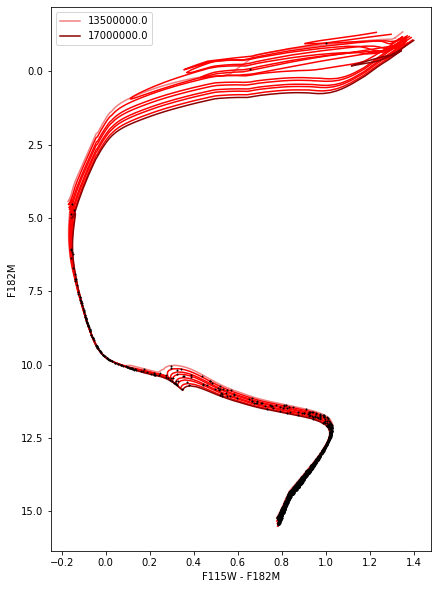

In [10]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
